In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors.oracle import Oracle

from tda.tracker.filters.linear_kalman import LinearKalman

In [6]:
sim = Simulation()

platform = LTIObject(1, np.array([0, 0, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_W = np.zeros((6, 6))
target_W[0, 0] = 0.25
target_W[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_W)

sim._sim_objects.extend([platform, target])

In [7]:
sim_records = sim.run()

In [ ]:
sim_records

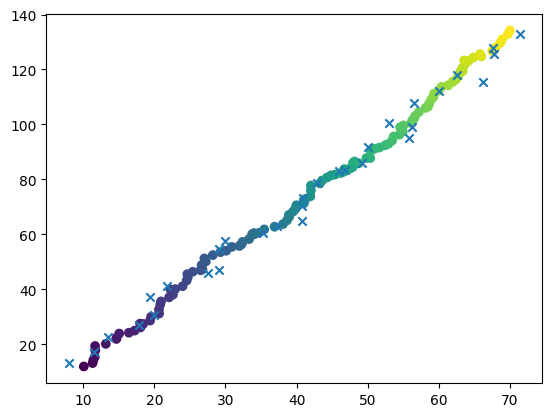

In [8]:
plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], c=sim_records["lti_object2"]["t"])
plt.scatter(sim_records["oracle1"]["target_x"], sim_records["oracle1"]["target_y"], marker="x")

In [ ]:
target.F

In [ ]:
sim.meas_queue